# Methods and models to test against the S&P 500
In this project we will be developing and evaluating three different quantitative investment strategies. Linear Regression, K-Means Clustering, and Bayesian Inference to determine their effectiveness we will be judging them against the S&P 500.

Before proceeding with analysis, I undertook comprehensive data cleaning and preprocessing steps to ensure the dataset was well structured and complete. The historical stock price data was gathered from Yahoo Finance using the yfinance and yahoo_fin python libraries. The fundamental data categories (e.g., financial ratios, earnings, dividends) were scraped from Yahoo Finance's statistics pages. The latest S&P 500 tickers were scraped from Wikipedia to ensure accurate stock listings. The stock price and stock fundamental datasets were merged into a single dataset. The two datasets were joined by their shared tickers. The date column required formatting to ensure it was set as a DateTime index. 

This dataset is now ready for exploratory data analysis to fully understand the data. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
file_path = "merged_yahoo_finance_data_final_cleaned.pkl"
df = pd.read_pickle(file_path)

# Display basic dataset information
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (891257, 61)

Column Names:
 Index([                                       'Date',
                                            'Ticker',
                                                   0,
                                  'Fiscal Year Ends',
                        'Most Recent Quarter  (mrq)',
                                     'Profit Margin',
                           'Operating Margin  (ttm)',
                           'Return on Assets  (ttm)',
                           'Return on Equity  (ttm)',
                                    'Revenue  (ttm)',
                          'Revenue Per Share  (ttm)',
                   'Quarterly Revenue Growth  (yoy)',
                               'Gross Profit  (ttm)',
                                            'EBITDA',
                   'Net Income Avi to Common  (ttm)',
                                'Diluted EPS  (ttm)',
                  'Quarterly Earnings Growth  (yoy)',
                                 'Tota

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_summary = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nMissing Values Summary:\n", missing_summary)


Missing Values Summary:
 Shares Short (8/31/2018) 4                     891257
Short % of Float (8/31/2018) 4                 891257
Short % of Shares Outstanding (8/31/2018) 4    891257
Shares Short (prior month 7/31/2018) 4         891257
Close                                          124626
Volume                                         124626
Shares Short (2/14/2025) 4                       1801
Short Ratio (2/14/2025) 4                        1801
Short % of Float (2/14/2025) 4                   1801
Short % of Shares Outstanding (2/14/2025) 4      1801
Shares Short (prior month 1/15/2025) 4           1801
Short Ratio (8/31/2018) 4                          77
dtype: int64


## Missing Value Strategy

There are extensive missing values for data in 2018 and less so for more recent 2025 data. Our models will not be dealing with 2025 so it is safe to ignore that missing data for now.  As for data missing in 2018 I could drop these columns as the missing data is extensive, but there is the possibility that this data gives important insights where it is available.  As the data missing is so extensive a reasonable assumption is that this data is missing not at random.  Since it appears we have the data both before and after the missing data period of 8/31/2018 a reasonable strategy is to use Linear interpolation using the average of the values before and after the missing data to fill this data shortfall.  

In [4]:
# Load the dataset
df = pd.read_pickle("merged_yahoo_finance_data_final_cleaned.pkl")

# Ensure "Date" is correctly formatted and set as index
if "Date" not in df.index.names:
    print("\n'Date' column is not in the index. Resetting index...")
    df.reset_index(inplace=True)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Identify columns related to 08/31/2018 short interest data
missing_2018_cols = [
    "Shares Short (8/31/2018) 4",
    "Short Ratio (8/31/2018) 4",
    "Short % of Float (8/31/2018) 4",
    "Short % of Shares Outstanding (8/31/2018) 4",
    "Shares Short (prior month 7/31/2018) 4"
]

# Convert columns to numeric (forcing errors='coerce' will set non-numeric values to NaN)
df[missing_2018_cols] = df[missing_2018_cols].apply(pd.to_numeric, errors="coerce")

# Find the closest available date to 08/31/2018 if it does not exist
target_date = pd.Timestamp("2018-08-31")
if target_date not in df["Date"].values:
    closest_date = df["Date"].loc[(df["Date"] - target_date).abs().idxmin()]
    print(f"\nDate 2018-08-31 NOT found. Using closest available date: {closest_date.date()}")
else:
    closest_date = target_date

# Apply linear interpolation for missing values in 2018-related columns
df[missing_2018_cols] = df[missing_2018_cols].interpolate(method="linear")

# Save the interpolated dataset
df.to_pickle("merged_yahoo_finance_data_interpolated.pkl")

# Print summary of missing values after interpolation
missing_summary = df[missing_2018_cols].isnull().sum()
print("\nMissing Values After Interpolation:")
print(missing_summary)


'Date' column is not in the index. Resetting index...

Missing Values After Interpolation:
Shares Short (8/31/2018) 4                     891257
Short Ratio (8/31/2018) 4                           1
Short % of Float (8/31/2018) 4                 891257
Short % of Shares Outstanding (8/31/2018) 4    891257
Shares Short (prior month 7/31/2018) 4         891257
dtype: int64


Interpolation failed for most of these values meaning there must be some missing data preventing the creation of a mean value for the stock data before and after 08/31/2018. Another issue is that Date is present but not as an index for time series analysis.   

In [5]:
# Load the dataset
df = pd.read_pickle("final_merged_stock_data_imputed.pkl")

# Ensure "Date" is in datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Set "Date" as the index if not already
if df.index.name != "Date":
    df.set_index("Date", inplace=True)
    print("'Date' column set as index.")

# Save the updated dataset
df.to_pickle("final_merged_stock_data_imputed_fixed.pkl")

# Confirm changes
print(f"\nDataset saved with fixed Date column. Shape: {df.shape}")
print("\nUpdated Dataset Preview:")
print(df.head())

'Date' column set as index.

Dataset saved with fixed Date column. Shape: (891257, 61)

Updated Dataset Preview:
            index Ticker           0 Fiscal Year Ends  \
Date                                                    
2018-01-02      0      A   64.009350       10/31/2024   
2018-01-02      1   NTRS   85.355996       12/31/2024   
2018-01-02      2   NTAP   45.767113        4/26/2024   
2018-01-02      3    NSC  126.090173       12/31/2024   
2018-01-02      4    NRG   23.877065       12/31/2024   

           Most Recent Quarter  (mrq) Profit Margin Operating Margin  (ttm)  \
Date                                                                          
2018-01-02                  1/31/2025        19.27%                  23.20%   
2018-01-02                 12/31/2024        24.49%                  35.60%   
2018-01-02                  1/24/2025        17.47%                  22.73%   
2018-01-02                 12/31/2024        21.63%                  37.67%   
2018-01-02   

In [6]:
# Load the dataset
df = pd.read_pickle("final_merged_stock_data_imputed.pkl")

# Ensure "Date" column is in datetime format and set as index
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors='coerce')

# Define columns related to 08/31/2018 short interest data
short_interest_cols = [
    "Shares Short (8/31/2018) 4",
    "Short Ratio (8/31/2018) 4",
    "Short % of Float (8/31/2018) 4",
    "Short % of Shares Outstanding (8/31/2018) 4",
    "Shares Short (prior month 7/31/2018) 4"
]

# Identify tickers with any missing short interest data before 08/31/2018
tickers_missing_0831 = df[df.index < "2018-08-31"].groupby("Ticker")[short_interest_cols].apply(lambda x: x.isna().any().any()).sum()

# Identify tickers with any missing short interest data before 07/31/2018
tickers_missing_0731 = df[df.index < "2018-07-31"].groupby("Ticker")[short_interest_cols].apply(lambda x: x.isna().any().any()).sum()

# Print results
print(f"\nTotal tickers with missing short interest data before 08/31/2018: {tickers_missing_0831}")
print(f"Total tickers with missing short interest data before 07/31/2018: {tickers_missing_0731}")


Total tickers with missing short interest data before 08/31/2018: 503
Total tickers with missing short interest data before 07/31/2018: 503


All 503 of the stocks are missing this short interest data prior to these dates, therefore dropping the columns before this 08/31/2018 is a reasonable step.  

In [7]:
# Load the dataset
df = pd.read_pickle("final_merged_stock_data_imputed.pkl")

# Define short interest columns from 8/31/2018 and 7/31/2018
short_interest_cols = [
    "Shares Short (8/31/2018) 4",
    "Short Ratio (8/31/2018) 4",
    "Short % of Float (8/31/2018) 4",
    "Short % of Shares Outstanding (8/31/2018) 4",
    "Shares Short (prior month 7/31/2018) 4"  # Include prior month for 07/31/2018
]

# Check which of the columns actually exist before dropping
existing_cols = [col for col in short_interest_cols if col in df.columns]

if not existing_cols:
    print("No matching short interest columns found. Nothing to drop.")
else:
    # Drop only the existing columns
    df_cleaned = df.drop(columns=existing_cols, errors="ignore")

    # Save the cleaned dataset
    df_cleaned.to_pickle("final_merged_stock_data_cleaned.pkl")

    # Confirm successful removal
    print(f"Cleaned dataset saved. New shape: {df_cleaned.shape}")
    print(f"Dropped columns: {existing_cols}")

Cleaned dataset saved. New shape: (891257, 57)
Dropped columns: ['Shares Short (8/31/2018) 4', 'Short Ratio (8/31/2018) 4', 'Short % of Float (8/31/2018) 4', 'Short % of Shares Outstanding (8/31/2018) 4', 'Shares Short (prior month 7/31/2018) 4']


The dataset contains more years than the our initial focus which will be learning from 2022 data in an effort to choose investments for 2023, so I am creating a data subset that focuses on these years. 

In [8]:
# Load the dataset
df = pd.read_pickle("final_merged_stock_data_filtered.pkl")

# Ensure "Date" column is correctly formatted
df["Date"] = pd.to_datetime(df["Date"])

# Select only data from 2022 and 2023
df_filtered = df.loc[(df["Date"].dt.year >= 2022) & (df["Date"].dt.year <= 2023)].copy()

# Save the filtered dataset
df_filtered.to_pickle("final_merged_stock_data_filtered_2022_2023.pkl")

# Print dataset shape after filtering
print(f"Filtered dataset shape: {df_filtered.shape}")

# Ensure necessary columns exist
required_columns = ["Ticker", "Close", "Volume", "Revenue  (ttm)"]
missing_columns = [col for col in required_columns if col not in df_filtered.columns]

if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# Ensure Volume is positive (avoid log issues)
df_filtered = df_filtered[df_filtered["Volume"] > 0]

# Log transformation for better visualization of highly skewed Volume
df_filtered["Log_Volume"] = np.log10(df_filtered["Volume"])

Filtered dataset shape: (249474, 57)


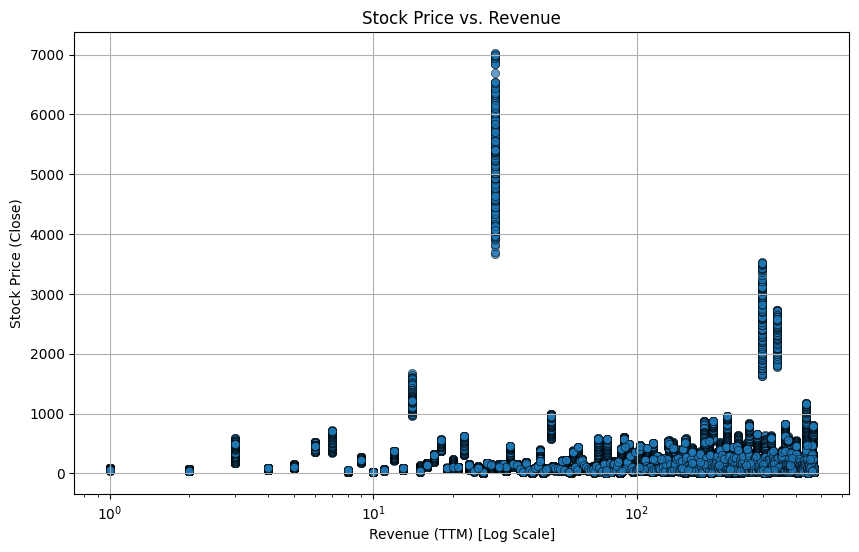

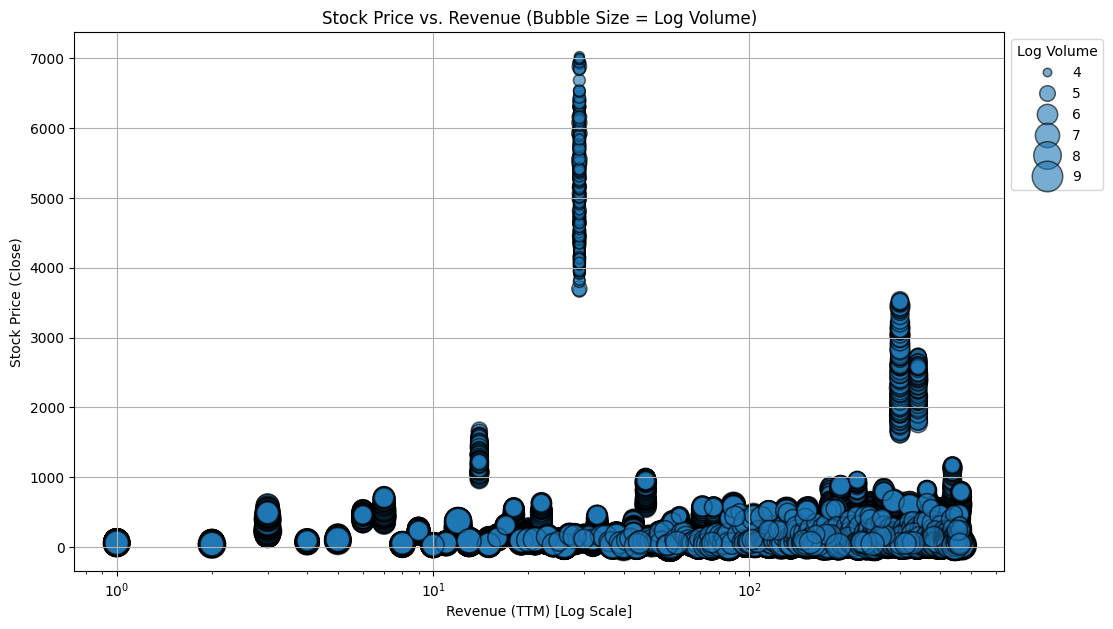

In [9]:
# Load the dataset
df = pd.read_pickle("final_merged_stock_data_filtered_2022_2023.pkl")

# Scatter Plot: Revenue vs. Stock Price
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_filtered["Revenue  (ttm)"], 
    y=df_filtered["Close"], 
    alpha=0.7, 
    edgecolor="black"
)
plt.xscale("log")  # Log scale to handle large value differences
plt.xlabel("Revenue (TTM) [Log Scale]")
plt.ylabel("Stock Price (Close)")
plt.title("Stock Price vs. Revenue")
plt.grid(True)
plt.show()

# Bubble Plot: Revenue vs. Stock Price (Bubble Size = Log Volume)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=df_filtered["Revenue  (ttm)"],
    y=df_filtered["Close"],
    size=df_filtered["Log_Volume"],  # Use log-transformed Volume for better scale
    alpha=0.6,
    edgecolor="black",
    sizes=(20, 500)  # Adjust bubble size scale
)
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Revenue (TTM) [Log Scale]")
plt.ylabel("Stock Price (Close)")
plt.title("Stock Price vs. Revenue (Bubble Size = Log Volume)")
plt.legend(title="Log Volume", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

Both the bubble plot and scatter plot provided limited insight into the direct impact of revenue on stock price. Therefore, developing an effective investment strategy will require a more robust classification method to better identify stocks and reveal their true investment potential.

## Next Steps

Using financial ratios and historical data we will attempt to determine how stock attributes (e.g. EPS, Revenue, Growth, Dividend Yield, etc.) influence stock performance.  A linear regression model can help quantify the relationship between features and stock behavior.  Linear regression should give us the means to show feature influence which should help us classify stocks as Growth, Value or Income.  After using regression to determine which features drive classifications applying One-Hot Encoding is deployed to categorize the stocks.  

###       Classification Rules:
 - Growth Stock = High EPS Growth, High ROE, Low Dividend Yield
 - Value Stock = Low P/E Ratio, High Book to Market, Moderate Dividend
 - Income Stock = High Dividend Yield, Stable Cash Flow, Low Volatility 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Load data
df = pd.read_pickle('final_merged_stock_data_filtered_2022_2023.pkl')

In [11]:
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Splitting the dataset
train_df = df[df['Date'].dt.year == 2022].copy()
test_df = df[df['Date'].dt.year == 2023].copy()

In [12]:
metrics = [
    'Revenue  (ttm)', 'Diluted EPS  (ttm)', 'Trailing Annual Dividend Yield 3', 
    'Return on Equity  (ttm)', 'Total Debt/Equity  (mrq)', 
    'Levered Free Cash Flow  (ttm)', 'Close'
]

# Create the cleaned datasets
def clean_data(df):
    columns_needed = [
        'Ticker', 'Date', 'Revenue  (ttm)', 'Diluted EPS  (ttm)',
        'Trailing Annual Dividend Yield 3', 'Return on Equity  (ttm)',
        'Total Debt/Equity  (mrq)', 'Levered Free Cash Flow  (ttm)', 'Close'
    ]
    
    df_clean = df[columns_needed].copy()
    for col in columns_needed:
        if col not in ['Ticker', 'Date']:
            df_clean[col] = pd.to_numeric(
                df_clean[col].replace({'%': '', ',': '', 'M': 'e6', 'B': 'e9'}, regex=True),
                errors='coerce'
            )
    df_clean.dropna(inplace=True)
    return df_clean

train_clean = clean_data(train_df)
test_clean = clean_data(test_df)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
#Linear Regression Model

# Drop non-numeric columns explicitly
X_train = train_clean.drop(['Close', 'Ticker', 'Date', 'Stock_Type'], axis=1, errors='ignore')
y_train = train_clean['Close']

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate training performance
y_pred_train = model.predict(X_train)
print(f'Training R²: {r2_score(y_train, y_pred_train):.4f}')

Training R²: 0.8517


In [15]:
# Define classification conditions (example):
conditions = [
    (test_clean['Trailing Annual Dividend Yield 3'] < 1) & 
    (test_clean['Revenue  (ttm)'] > train_clean['Revenue  (ttm)'].quantile(0.75)),
    
    (test_clean['Diluted EPS  (ttm)'] > train_clean['Diluted EPS  (ttm)'].median()) &
    (test_clean['Total Debt/Equity  (mrq)'] < 0.5),
    
    (test_clean['Trailing Annual Dividend Yield 3'] >= 3)
]

labels = ['Growth', 'Value', 'Income']
test_clean['Stock_Type'] = np.select(conditions, labels, default='Value')

# Example assuming you have a dataframe 'test_clean' already classified
encoder = OneHotEncoder(sparse_output=False)
encoded_labels = encoder.fit_transform(test_clean[['Stock_Type']])

encoded_df = pd.DataFrame(
    encoded_labels, 
    columns=encoder.categories_[0], 
    index=test_clean.index
)

# Explicitly ensure Ticker column still exists in test_clean
final_df = pd.concat([test_clean[['Ticker']].reset_index(drop=True), encoded_df.reset_index(drop=True), 
                      test_clean.drop(['Stock_Type', 'Ticker'], axis=1).reset_index(drop=True)], axis=1)

# Verify clearly
print(final_df.head())

  Ticker  Growth  Income  Value       Date  Revenue  (ttm)  \
0    NEE     0.0     0.0    1.0 2023-01-03    2.475000e+10   
1    NEM     0.0     0.0    1.0 2023-01-03    1.868000e+10   
2   NFLX     1.0     0.0    0.0 2023-01-03    3.900000e+10   
3     NI     0.0     0.0    1.0 2023-01-03    5.460000e+09   
4    NKE     0.0     0.0    1.0 2023-01-03    4.898000e+10   

   Diluted EPS  (ttm)  Trailing Annual Dividend Yield 3  \
0                3.37                              2.94   
1                2.86                              2.28   
2               19.85                              0.00   
3                1.62                              2.79   
4                3.24                              1.94   

   Return on Equity  (ttm)  Total Debt/Equity  (mrq)  \
0                     9.51                    137.30   
1                    11.17                     29.80   
2                    38.44                     72.73   
3                     8.12                    13

In [16]:
def calculate_scores(df, stock_type):
    df = df.copy()
    
    if stock_type == 'Growth':
        # Growth stocks: Prioritize EPS growth, ROE, and Revenue growth
        df['Score'] = (
            (df['Diluted EPS  (ttm)'].rank(pct=True) * 0.4) +
            (df['Return on Equity  (ttm)'].rank(pct=True) * 0.3) +
            (df['Revenue  (ttm)'].rank(pct=True) * 0.3)
        )
        
    elif stock_type == 'Value':
        # Value stocks: Lower debt, good earnings, moderate dividends
        df['Score'] = (
            (df['Diluted EPS  (ttm)'].rank(pct=True) * 0.3) +
            ((1 / df['Total Debt/Equity  (mrq)']).rank(pct=True) * 0.4) +
            (df['Revenue  (ttm)'].rank(pct=True) * 0.3)
        )

    elif stock_type == 'Income':
        # Income stocks: Highest dividend yield, sustainable cash flow, moderate debt
        df['Score'] = (
            (df['Trailing Annual Dividend Yield 3'].rank(pct=True) * 0.6) +
            ((1 / df['Total Debt/Equity  (mrq)']).rank(pct=True) * 0.2) +
            (df['Levered Free Cash Flow  (ttm)'].rank(pct=True) * 0.2)
        )

    return df.sort_values('Score', ascending=False)

In [17]:
# Aggregate test data clearly by Ticker (mean values over the test period)
agg_test_df = test_clean.groupby('Ticker').agg({
    'Revenue  (ttm)': 'mean',
    'Diluted EPS  (ttm)': 'mean',
    'Trailing Annual Dividend Yield 3': 'mean',
    'Return on Equity  (ttm)': 'mean',
    'Total Debt/Equity  (mrq)': 'mean',
    'Levered Free Cash Flow  (ttm)': 'mean',
    'Close': 'mean'
}).reset_index()

# Then classify again on this aggregated DataFrame:
conditions = [
    (agg_test_df['Trailing Annual Dividend Yield 3'] < 1) & 
    (agg_test_df['Revenue  (ttm)'] > train_clean['Revenue  (ttm)'].quantile(0.75)),
    
    (agg_test_df['Diluted EPS  (ttm)'] > train_clean['Diluted EPS  (ttm)'].median()) &
    (agg_test_df['Total Debt/Equity  (mrq)'] < 0.5),
    
    (agg_test_df['Trailing Annual Dividend Yield 3'] >= 3)
]

labels = ['Growth', 'Value', 'Income']
agg_test_df['Stock_Type'] = np.select(conditions, labels, default='Value')

# Apply scoring function to aggregated data
growth_scored = calculate_scores(agg_test_df[agg_test_df['Stock_Type']=='Growth'], 'Growth').head(30)
value_scored = calculate_scores(agg_test_df[agg_test_df['Stock_Type']=='Value'], 'Value').head(20)
income_scored = calculate_scores(agg_test_df[agg_test_df['Stock_Type']=='Income'], 'Income').head(10)

# Combine clearly
portfolio_df = pd.concat([growth_scored, value_scored, income_scored])

# Allocate percentages explicitly
portfolio_df['Allocation %'] = 0.0
portfolio_df.loc[portfolio_df['Stock_Type']=='Growth', 'Allocation %'] = 0.70 / len(growth_scored)
portfolio_df.loc[portfolio_df['Stock_Type']=='Value', 'Allocation %'] = 0.20 / len(value_scored)
portfolio_df.loc[portfolio_df['Stock_Type']=='Income', 'Allocation %'] = 0.10 / len(income_scored)

print(portfolio_df[['Ticker', 'Revenue  (ttm)', 'Diluted EPS  (ttm)', 
                    'Trailing Annual Dividend Yield 3', 'Stock_Type', 'Allocation %']])

    Ticker  Revenue  (ttm)  Diluted EPS  (ttm)  \
197    HCA    7.060000e+10               22.01   
272   META    1.645000e+11               23.86   
60   BRK-B    3.714300e+11               41.27   
93     COR    3.031900e+11                7.05   
80    CHTR    5.508000e+10               34.96   
94    COST    2.640900e+11               17.14   
1     AAPL    3.957600e+11                6.31   
287   MSFT    2.618000e+11               12.42   
189   GOOG    3.500200e+11                8.05   
190  GOOGL    3.500200e+11                8.03   
255    LLY    4.504000e+10               11.68   
295   NFLX    3.900000e+10               19.85   
281    MOH    3.916000e+10               20.43   
265     MA    2.817000e+10               13.91   
31    AMZN    6.379600e+11                5.54   
400    UAL    5.706000e+10                9.45   
409      V    3.680000e+10                9.91   
304   NVDA    1.305000e+11                2.94   
384    TMO    4.288000e+10               16.52   


In [18]:
feature_columns = [
    'Revenue  (ttm)', 
    'Diluted EPS  (ttm)', 
    'Levered Free Cash Flow  (ttm)',
    'Return on Equity  (ttm)', 
    'Total Debt/Equity  (mrq)',
    'Trailing Annual Dividend Yield 3'
]
# Ensure these columns are numeric and clean
X_test = test_clean.drop(['Close', 'Ticker', 'Date', 'Stock_Type'], axis=1, errors='ignore')

y_train = train_clean['Close']
y_test = test_clean['Close']


# Explicitly evaluate test data
y_pred_test = model.predict(X_test)

# Compute R-squared and RMSE
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Test R²: {test_r2:.4f}')
print(f'Test RMSE: {test_rmse:.2f}')

Test R²: 0.8530
Test RMSE: 115.43


### Portfolio Strategy
The goal of this portfolio is soley to outperform the S&P 500 during the test period of 2023 by prioritizing Growth Stocks.  If correctly categorized by this model the Growth Stocks should offer a higher return than Value or Income stocks. The portfolio allocates 70% to Growth Stocks, 20% to Value Stocks and 10% Income Stocks.  This strategy leans heavily towards Growth Stocks in an attempt to capture high returns when applied to the test period, while Value and Income Stocksserve the purpose of risk management and diversification.

In [19]:
import yfinance as yf

# Define investment period clearly
invest_start_date = '2018-01-01'
invest_end_date = '2023-12-31'

# Download SPY data
spy = yf.download("SPY", start=invest_start_date, end=invest_end_date)['Close']

# Save locally for reuse
spy.to_pickle('SPY_18_23.pkl')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [20]:
# Load previously saved SPY data
spy = pd.read_pickle('SPY_18_23.pkl')

# Define dates 
start_date = '2023-01-03'  
end_date = '2023-12-29'

# Get starting prices
start_prices = test_df[test_df['Date'] == start_date][['Ticker', 'Close']].set_index('Ticker')['Close']

# Get ending prices
end_prices = test_df[test_df['Date'] == end_date][['Ticker', 'Close']].set_index('Ticker')['Close']

# Align with portfolio stocks
portfolio_df['Start_Price'] = portfolio_df['Ticker'].map(start_prices)
portfolio_df['End_Price'] = end_prices[portfolio_df['Ticker']].values

In [21]:
# Individual Stock returns
portfolio_df['Stock_Return'] = ((portfolio_df['End_Price'] - portfolio_df['Start_Price']) / portfolio_df['Start_Price']) * 100

# Weighted Portfolio return
portfolio_df['Weighted_Return'] = portfolio_df['Stock_Return'] * portfolio_df['Allocation %']
total_portfolio_return = portfolio_df['Weighted_Return'].sum()

In [22]:
initial_investment = 10_000_000  # $10 million initial investment

# Portfolio final value
portfolio_final_value = initial_investment * (1 + total_portfolio_return / 100)

# SPY final value
spy_start_price = spy.loc[start_date]
spy_end_price = spy.loc[end_date]

if isinstance(spy_start_price, pd.Series):
    spy_start_price = spy_start_price.iloc[0]

if isinstance(spy_end_price, pd.Series):
    spy_end_price = spy_end_price.iloc[0]

# Calculate return
spy_return = ((spy_end_price - spy_start_price) / spy_start_price) * 100
Portfolio_final_value = initial_investment * (1 + total_portfolio_return / 100)

# Results
print("=== Portfolio vs S&P 500 (2023) ===")
print(f"Portfolio Return: {total_portfolio_return:.2f}%")
print(f"S&P 500 (SPY) Return: {spy_return:.2f}%")

print(f"\nPortfolio Final Value: ${portfolio_final_value:,.2f}")

=== Portfolio vs S&P 500 (2023) ===
Portfolio Return: 44.43%
S&P 500 (SPY) Return: 26.71%

Portfolio Final Value: $14,443,489.52


In [23]:
# Prepare data for plot 

# S&P
spy_2023 = spy.loc['2023-01-03':'2023-12-29']
spy_shares = initial_investment / spy_2023.iloc[0]
initial_investment = 10_000_000
spy_daily_value = spy_2023 * spy_shares



# Get list of portfolio tickers
selected_tickers = portfolio_df['Ticker'].tolist()

# Filter 2023 test data for selected tickers
portfolio_prices = test_df[
    (test_df['Ticker'].isin(selected_tickers)) & 
    (test_df['Date'].between('2023-01-03', '2023-12-29'))
].pivot(index='Date', columns='Ticker', values='Close')

# Sort dates for accuracy
portfolio_prices = portfolio_prices.sort_index()

initial_investment = 10_000_000

# Allocate initial investment clearly according to allocation %
allocations = portfolio_df.set_index('Ticker')['Allocation %']
initial_allocations = initial_investment * allocations

# Calculate number of shares purchased at start of 2023
shares_owned = initial_allocations / portfolio_prices.iloc[0]

# Daily portfolio value calculation
daily_portfolio_value = portfolio_prices.mul(shares_owned, axis=1).sum(axis=1)

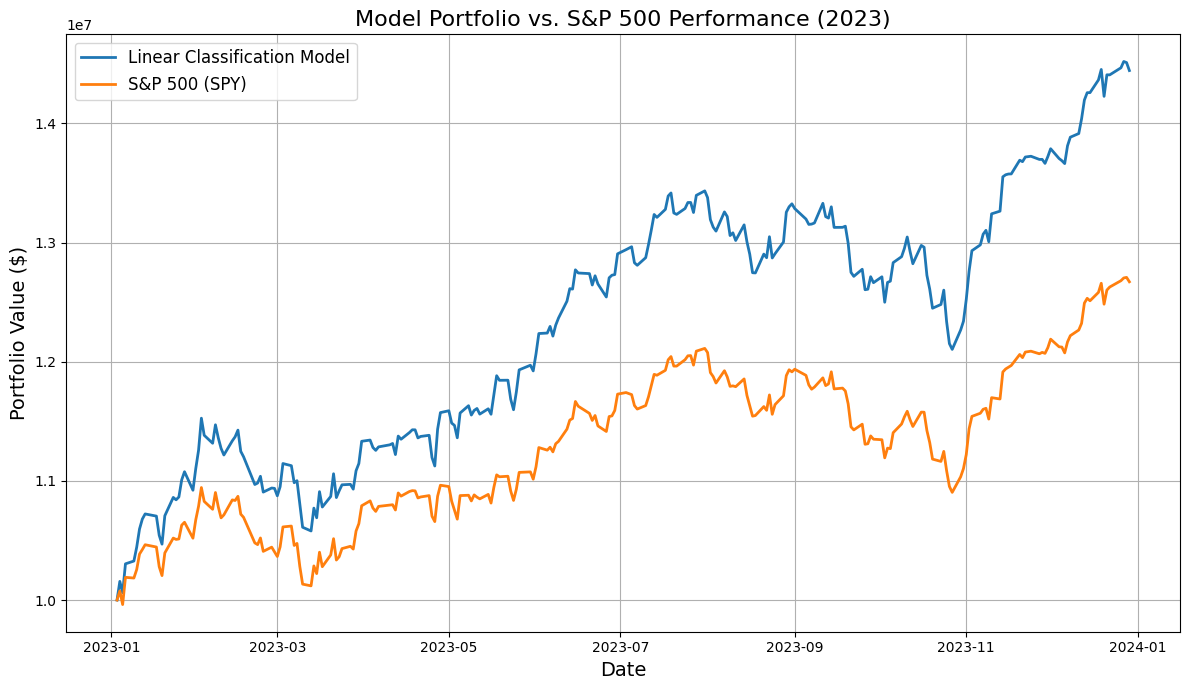

In [24]:
# Plot
plt.figure(figsize=(12, 7))
plt.plot(daily_portfolio_value.index, daily_portfolio_value, label='Linear Classification Model', linewidth=2)
plt.plot(spy_daily_value.index, spy_daily_value, label='S&P 500 (SPY)', linewidth=2)

plt.title('Model Portfolio vs. S&P 500 Performance (2023)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Linear Regression Model Conclusion

This Linear Regression Model demonstrates strong predictive capability. The training of 0.8517 and test of 0.8530 indicate that the model was generalizable to the to the test data. The Root Mean Squared error of 115.43 model was on average within $115.43 of predicted stock which shows it is an effective model for predicting stock price. 

When tested against a realistic investment scenario for 2023, the model selected portfolio that significantly outperformed the S&P 500. With an impressive Annual Return of 44.43%, exceeding the S&P 500 26.71% for the same calendar year. The initial investment of grew to by years end highlighting the model's strong potential as a superior investment performance. 

However, the RMSE value indicates a difference between actual and predicted stock price that shows room for improvement. Given the inherent volatility of the stock market, developing a model that minimizes prediction errors could enhance reliability and effectiveness. 

## Next Steps

While Linear Regression has proven to be more effective than expected for portfolio selection attempting machine learning for this task is an obvious next step. K-Means clustering stocks based on relevant financial indicators to uncover any underlying trends that linear regression may fail to reveal is a good next step. 

K-Means identifies hidden trends by discovering natural groupings in data. This process groups stocks purely on their financial attributes instead of using predefined labels. For portfolio allocation we will identify which clusters correspond with Growth, Value and Income Stocks. After identification the same portfolio strategy of 70% Growth, 20% Value and 10% Income will be used. 


In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [26]:
# Datasets for K-Means Clustering Model
cluster_train_df = df[df['Date'].dt.year == 2022].copy()
cluster_test_df = df[df['Date'].dt.year == 2023].copy()

# Aggregate training data (2022)
train_cluster_df = train_clean.groupby('Ticker').agg({
    'Diluted EPS  (ttm)': 'mean',
    'Trailing Annual Dividend Yield 3': 'mean',
    'Revenue  (ttm)': 'mean',
    'Return on Equity  (ttm)': 'mean',
    'Total Debt/Equity  (mrq)': 'mean',
    'Levered Free Cash Flow  (ttm)': 'mean',
}).dropna()

# Standardize and run K-Means
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_cluster_df)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
train_cluster_labels = kmeans.fit_predict(X_train_scaled)

# Clearly label the aggregated data
train_cluster_df['Cluster'] = train_cluster_labels

In [27]:
# Merge cluster labels back clearly by Ticker
train_clean = train_clean.merge(
    train_cluster_df['Cluster'], 
    on='Ticker', 
    how='left'
)

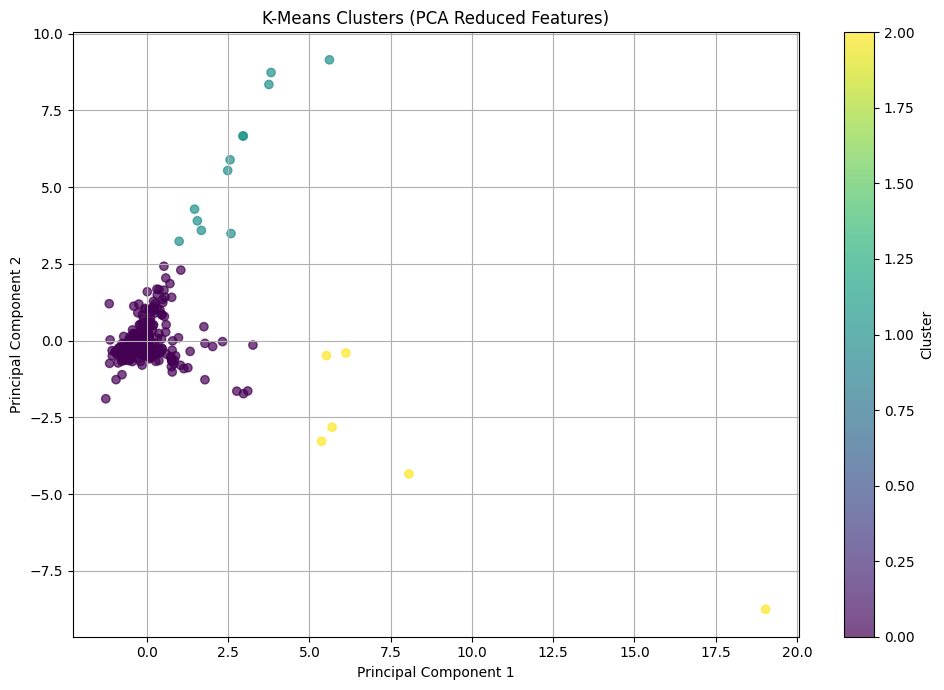

In [28]:
from sklearn.decomposition import PCA 

# Principle Component Analysis
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_train_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clusters (PCA Reduced Features)')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [29]:
# Add K-Means cluster labels to aggregated dataframe
train_cluster_df['Cluster'] = kmeans.labels_

# Inspect clusters 
print(train_cluster_df.groupby('Cluster').mean())

         Diluted EPS  (ttm)  Trailing Annual Dividend Yield 3  Revenue  (ttm)  \
Cluster                                                                         
0                  7.627452                          1.869500    2.422846e+10   
1                 11.485833                          1.058333    3.712067e+11   
2                  9.635000                          1.656667    9.390833e+10   

         Return on Equity  (ttm)  Total Debt/Equity  (mrq)  \
Cluster                                                      
0                      23.518452                121.718929   
1                      40.747500                 48.292500   
2                     422.561667               3164.943333   

         Levered Free Cash Flow  (ttm)  
Cluster                                 
0                         2.231117e+09  
1                         4.277917e+10  
2                         3.336520e+09  


In [30]:
# Assign clusters 
growth_cluster = 0
value_cluster = 1
income_cluster = 2

# Select top stocks from each cluster based on relevant criteria (example: EPS)
growth_stocks = train_cluster_df[train_cluster_df['Cluster']==growth_cluster].sort_values('Diluted EPS  (ttm)', ascending=False).head(30)
value_stocks = train_cluster_df[train_cluster_df['Cluster']==value_cluster].sort_values('Diluted EPS  (ttm)', ascending=False).head(20)
income_stocks = train_cluster_df[train_cluster_df['Cluster']==income_cluster].sort_values(by='Trailing Annual Dividend Yield 3', ascending=False).head(10)

# Combine into one clear portfolio
portfolio_df = pd.concat([growth_stocks, value_stocks, income_stocks]).reset_index()

In [31]:
# Portfolio Allocations 
portfolio_df['Allocation %'] = 0.0

portfolio_df.loc[portfolio_df['Cluster']==growth_cluster, 'Allocation %'] = 0.70 / len(growth_stocks)
portfolio_df.loc[portfolio_df['Cluster']==value_cluster, 'Allocation %'] = 0.20 / len(value_stocks)
portfolio_df.loc[portfolio_df['Cluster']==income_cluster, 'Allocation %'] = 0.10 / len(income_stocks)

In [32]:
# Capital allocation 

initial_investment = 10_000_000

# Get prices explicitly
start_date = '2023-01-03'
end_date = '2023-12-29'

start_prices = test_df[test_df['Date'] == start_date][['Ticker', 'Close']].set_index('Ticker')['Close']
end_prices = test_df[test_df['Date'] == end_date][['Ticker', 'Close']].set_index('Ticker')['Close']

# Merge prices explicitly
portfolio_df['Start_Price'] = portfolio_df['Ticker'].map(start_prices)
portfolio_df['End_Price'] = portfolio_df['Ticker'].map(end_prices)

# Calculate returns
portfolio_df['Stock_Return'] = ((portfolio_df['End_Price'] - portfolio_df['Start_Price']) / portfolio_df['Start_Price']) * 100
portfolio_df['Weighted_Return'] = portfolio_df['Stock_Return'] * portfolio_df['Allocation %']
total_portfolio_return = portfolio_df['Weighted_Return'].sum()

In [33]:
# K-Means Portfolio vs S&P

# Model Portfolio 
portfolio_final_value = initial_investment * (1 + total_portfolio_return / 100)

#S&P Portfolio 
initial_investment = 10_000_000
spy_start_price = spy.loc[start_date]
spy_end_price = spy.loc[end_date]

# Convert Series to scalar explicitly
spy_start_price = spy_start_price.iloc[0] if isinstance(spy_start_price, pd.Series) else spy_start_price
spy_end_price = spy_end_price.iloc[0] if isinstance(spy_end_price, pd.Series) else spy_end_price

# Calculate scalar return explicitly
spy_return = ((spy_end_price - spy_start_price) / spy_start_price) * 100

# Print clearly
print("=== The Model (K-Means) Portfolio vs. S&P 500 (2023) ===")
print(f"The Model Portfolio Return: {total_portfolio_return:.2f}%")
print(f"The Model Portfolio Final Value: ${portfolio_final_value:,.2f}")
print(f"S&P 500 (SPY) Return: {spy_return:.2f}%\n")

=== The Model (K-Means) Portfolio vs. S&P 500 (2023) ===
The Model Portfolio Return: 31.49%
The Model Portfolio Final Value: $13,149,475.47
S&P 500 (SPY) Return: 26.71%



In [34]:
# Plotting data 

# Get tickers
portfolio_tickers = portfolio_df['Ticker'].unique()

# Get daily closing prices for K-Means selected stocks in 2023
portfolio_prices_2023 = test_df[
    (test_df['Ticker'].isin(portfolio_df['Ticker'])) &
    (test_df['Date'].between('2023-01-03', '2023-12-29'))
].pivot(index='Date', columns='Ticker', values='Close').sort_index()

initial_investment = 10_000_000

# Align allocation % with stock tickers
allocations = portfolio_df.set_index('Ticker')['Allocation %']

# Calculate number of shares bought clearly on the first day
initial_prices = portfolio_prices_2023.iloc[0]
shares_owned = (allocations * initial_investment) / initial_prices

# Clearly calculate portfolio daily value
daily_portfolio_value = portfolio_prices_2023.mul(shares_owned, axis=1).sum(axis=1)

In [35]:
# SPY value
spy_initial_investment = 10_000_000
spy_2023 = spy.loc['2023-01-03':'2023-12-29']
spy_shares = spy_initial_investment / spy_2023.iloc[0]
spy_daily_value = spy_2023 * spy_shares

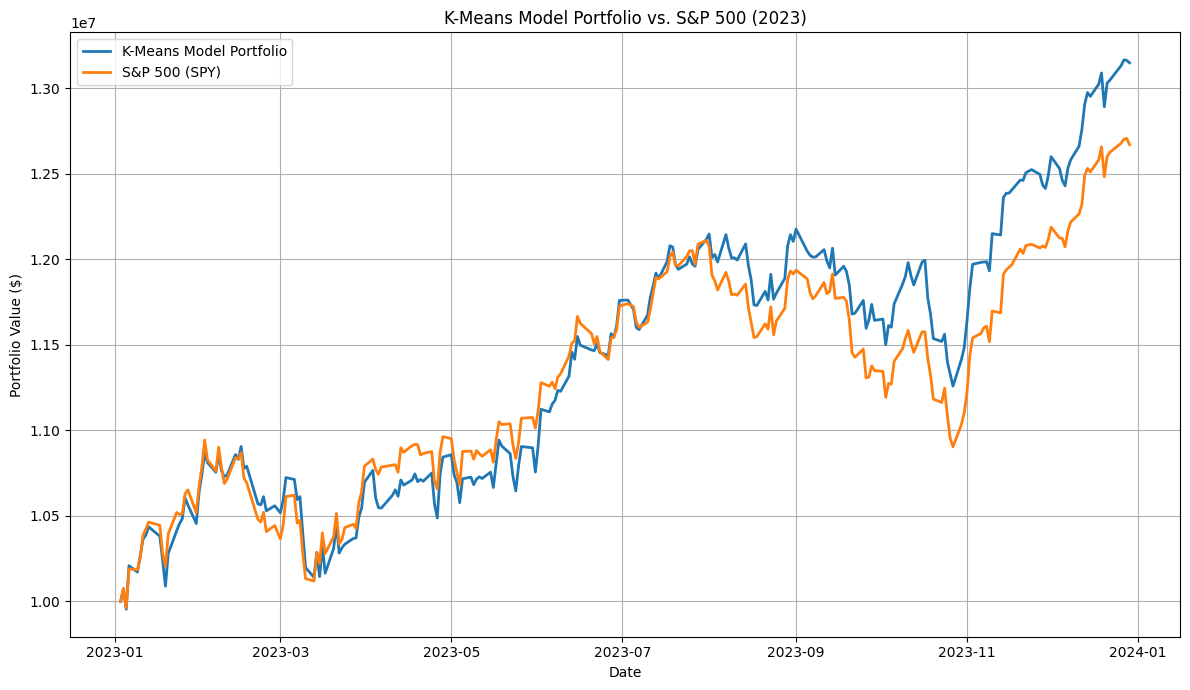

In [36]:
# Plot
plt.figure(figsize=(12, 7))

plt.plot(daily_portfolio_value.index, daily_portfolio_value, label='K-Means Model Portfolio', linewidth=2)
plt.plot(spy_daily_value.index, spy_daily_value, label='S&P 500 (SPY)', linewidth=2)

plt.title('K-Means Model Portfolio vs. S&P 500 (2023)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import silhouette_score

# Silhouette Score
sil_score_train = silhouette_score(X_train_scaled, kmeans.labels_)
print(f"Silhouette Score (Training Data 2022): {sil_score_train:.4f}")

Silhouette Score (Training Data 2022): 0.7361


In [38]:
# Silhouette Score for 2023 test Data
numeric_cols = [
    'Diluted EPS  (ttm)',
    'Trailing Annual Dividend Yield 3',
    'Revenue  (ttm)',
    'Return on Equity  (ttm)',
    'Total Debt/Equity  (mrq)',
    'Levered Free Cash Flow  (ttm)'  # explicitly include this missing column
]
# Numeric conversion
for col in numeric_cols:
    cluster_test_df[col] = pd.to_numeric(
        cluster_test_df[col].replace({'%':'', ',':'', 'M':'e6', 'B':'e9'}, regex=True),
        errors='coerce'
    )

# Explicit 
test_cluster_agg = cluster_test_df.groupby('Ticker')[numeric_cols].mean().dropna()

# Scaling 
X_test_scaled = scaler.transform(test_cluster_agg)

# Predict clusters
test_labels = kmeans.predict(X_test_scaled)

# Calculate Silhouette Score 
test_silhouette = silhouette_score(X_test_scaled, test_labels)
print(f"Silhouette Score (Test Data 2023): {test_silhouette:.4f}")

Silhouette Score (Test Data 2023): 0.7365


## K-Means Clustering Model Conclusion

The K-Means clustering model demonstrates effective stock categorization, evidenced by a good Silhouette Score of 0.7361 for the training data, and 0.7365 for the testing data. Indicating that the clusters formed were well defined and stable. 
In the 2023 investment scenario, the portfolio selected using K-Means clustering achieved a return of 31.49% clearly outperforming the S&P 500. The initial investment of $10,000,000 grew to $13,149,475.47 by the end of 2023 highlighting the model as capable for identifying stocks with good investment potential outperforming the S&P which at 26.71% had strong returns. The implementation of K-Means clustering was inspired by the methods presented in Zhao Gao's "The application of artificial intelligence in stock investment" (2020). 

However, compared to the earlier Linear Regression Classification model which achieved significantly higher returns this model fell short of expectations. The initial indication is that the supervised learning approach for leveraging fundamental analysis may have a stronger predictive advantage. That said the e K-Means model demonstrates potential for unsupervised learning methods being valuable for stock categorization and strategic portfolio selection.
## Next Steps

To further improve this investment approach exploring Bayesian Inference as a method to integrate prior knowledge from either the Linear Regression or K-Means Clustering models while adapting to new data. By leverage these previous insights and dynamically updating the model this approach lays a framework for an almost automated portfolio strategy that will evolve over the test period. The adaptability is especially valuable in a market where conditions can rapidly shift. 

To improve upon the classifications of the Linear Regression model the Bayesian model will incorporate uncertainty into the model estimates which should ensure more robust portfolio allocation throughout the test year by capturing the distribution of possible outcomes and offering probabilistic perspective on portfolio allocations. 

This approach will lean on the priors of the linear regression model using it's coefficients as a framework to learn from historical data while allowing flexibility. The Bayesian approach will still model stock performance as a function of financial ratios, but instead of a single estimate the Bayesian approach will provide a distribution of possible values for each stock category. 
The expectation is that model will improve classification accuracy, allow for a dynamic portfolio strategy adjusting allocations with a changing market, and provides improved risk management. 

In [39]:
import pymc as pm

In [40]:
# Allow Bayesian model access to Q3 & Q4
bayesian_train_df = df[
    (df['Date'] >= '2022-07-01') &
    (df['Date'] <= '2022-12-31')
].copy()

# Clean data
bayesian_train_df_clean = clean_data(bayesian_train_df)

In [41]:
# Example Linear Regression-based classification:
conditions = [
    (bayesian_train_df_clean['Trailing Annual Dividend Yield 3'] < 1) & 
    (bayesian_train_df_clean['Revenue  (ttm)'] > bayesian_train_df_clean['Revenue  (ttm)'].quantile(0.75)),
    
    (bayesian_train_df_clean['Diluted EPS  (ttm)'] > bayesian_train_df_clean['Diluted EPS  (ttm)'].median()) &
    (bayesian_train_df_clean['Total Debt/Equity  (mrq)'] < 0.5),
    
    (bayesian_train_df_clean['Trailing Annual Dividend Yield 3'] >= 3)
]

labels = ['Growth', 'Value', 'Income']
bayesian_train_df_clean['Stock_Type'] = np.select(conditions, labels, default='Value')

In [42]:
# Define numeric priors
stock_type_priors = {
    'Growth': {'eps_mu': 10.0, 'eps_sigma': 2.0},
    'Value': {'eps_mu': 5.0, 'eps_sigma': 2.5},
    'Income': {'eps_mu': 3.0, 'eps_sigma': 1.0}
}

bayesian_train_df_clean['eps_prior_mu'] = bayesian_train_df_clean['Stock_Type'].map(
    lambda x: stock_type_priors[x]['eps_mu']
)

bayesian_train_df_clean['eps_prior_sigma'] = bayesian_train_df_clean['Stock_Type'].map(
    lambda x: stock_type_priors[x]['eps_sigma']
)


In [43]:
# Prepare data arrays
eps = pd.to_numeric(bayesian_train_df_clean['Diluted EPS  (ttm)'], errors='coerce').values
observed_close = pd.to_numeric(bayesian_train_df_clean['Close'], errors='coerce').values
eps_prior_mu = bayesian_train_df_clean['eps_prior_mu'].values
eps_prior_sigma = bayesian_train_df_clean['eps_prior_sigma'].values

# Explicitly remove NaNs
valid_idx = ~np.isnan(eps) & ~np.isnan(observed_close)
eps = eps[valid_idx]
observed_close = observed_close[valid_idx]
eps_prior_mu = eps_prior_mu[valid_idx]
eps_prior_sigma = eps_prior_sigma[valid_idx]

In [44]:
lin_coefs = model.coef_  # Extract coefficients from trained LinearRegression model
lin_intercept = model.intercept_

print("Linear Regression Coefficients:", lin_coefs)
print("Linear Regression Intercept:", lin_intercept)

Linear Regression Coefficients: [ 2.10835839e-11  8.84719762e+00 -5.42321308e-02  2.16400405e-05
 -5.15351586e-03 -4.39497327e-10]
Linear Regression Intercept: 78.4112729070014


In [46]:
print("X_train_np features:", list(X_train.columns))
print("lin_coefs expected features:", lin_coefs.shape[0])  # Number of expected features

X_train_np features: ['Revenue  (ttm)', 'Diluted EPS  (ttm)', 'Trailing Annual Dividend Yield 3', 'Return on Equity  (ttm)', 'Total Debt/Equity  (mrq)', 'Levered Free Cash Flow  (ttm)']
lin_coefs expected features: 6


In [47]:
# Define the exact order of features used in Linear Regression
selected_features = ['Revenue  (ttm)', 'Diluted EPS  (ttm)', 'Trailing Annual Dividend Yield 3',
                     'Return on Equity  (ttm)', 'Total Debt/Equity  (mrq)', 'Levered Free Cash Flow  (ttm)']

# Apply valid_idx to bayesian_train_df_clean FIRST
filtered_df = bayesian_train_df_clean[valid_idx]

# Now create X_train from the filtered data
X_train = filtered_df[selected_features]
X_train_np = X_train.to_numpy()

# Verify shapes
print("Final X_train_np shape:", X_train_np.shape)  
print("lin_coefs shape:", lin_coefs.shape)
print("Filtered X_train shape:", X_train.shape)
print("Filtered eps shape:", eps.shape)
print("Filtered observed_close shape:", observed_close.shape)

Final X_train_np shape: (55510, 6)
lin_coefs shape: (6,)
Filtered X_train shape: (55510, 6)
Filtered eps shape: (55510,)
Filtered observed_close shape: (55510,)


In [ ]:
# Function to convert 'B', 'M', 'K' to numerical values
def convert_str_to_float(value):
    if isinstance(value, str):
        value = value.replace(',', '')  
        if 'B' in value:
            return float(value.replace('B', '')) * 1e9
        elif 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'K' in value:
            return float(value.replace('K', '')) * 1e3
        else:
            return float(value)  
    return value  

# Fix duplicate tickers before reindexing
end_week_data = end_week_data.drop_duplicates(subset=['Ticker'], keep='last')

# Ensure X_week is a DataFrame
if not isinstance(X_week, pd.DataFrame):
    X_week = pd.DataFrame(X_week, columns=feature_names)  

# Convert string values to float
X_week = X_week.map(convert_str_to_float)
X_week = X_week.to_numpy(dtype=float)

In [67]:
import multiprocessing as mp

# Bayesian Model

with pm.Model() as bayesian_portfolio_model:
    # Priors informed by linear regression coefficients
    coefs = pm.Normal("coefs", mu=lin_coefs, sigma=1, shape=(X_train_np.shape[1],))
    intercept = pm.Normal("intercept", mu=lin_intercept, sigma=1)
    
    # Additional prior informed by domain knowledge
    eps_coef = pm.Normal('eps_coef', mu=eps_prior_mu, sigma=eps_prior_sigma)
    
    # Ensure correct dot product shape
    mu_linear = pm.math.dot(X_train_np, coefs).flatten()

    # Define deterministic variable to store `coefs` and store in psterior
    coefs_det = pm.Deterministic("coefs_det", coefs) 

    # Ensure eps broadcasts correctly
    eps_term = (eps_coef * eps).flatten()

    # Define the expected mean combining both effects
    mu = intercept + mu_linear + eps_term

    # Likelihood function with specified sigma
    sigma = pm.HalfNormal('sigma', sigma=115.43)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=observed_close)

    # Sampling with explicit settings for stability and convergence
    trace = pm.sample(
        draws=1000,                # More iterations for better accuracy
        tune=750, 
        cores=2,            
        chains=4,           # Explicitly recommended for reliable convergence checks
        random_seed=42, 
        target_accept=0.95, # Reduces tree-depth warnings
        max_treedepth=10,  # Improves exploration
        init="jitter+adapt_diag_grad",
        mp_ctx=mp.get_context("spawn"), # Enables stable multiprocessing
        progressbar=True
    )
# Sample posterior 
with bayesian_portfolio_model:
    post_pred = pm.sample_posterior_predictive(trace, var_names=['coefs_det'], random_seed=42)

# Extract coefs 
coefs_mean = trace.posterior["coefs_det"].mean(dim=("chain", "draw"))

# Ensure matrix dimensions match before multiplication
coefs_mean_np = np.array(coefs_mean[:X_week.shape[1]], dtype=float).reshape(-1, 1)
predicted_prices = X_week @ coefs_mean_np

Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [coefs, intercept, eps_coef, sigma]


Output()

Sampling 4 chains for 750 tune and 1_000 draw iterations (3_000 + 4_000 draws total) took 2417 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: []


Output()

In [53]:
print("X_week shape:", X_week.shape)
print("coefs_mean_np shape:", coefs_mean_np.shape)

X_week shape: (2490, 2)
coefs_mean_np shape: (6,)


In [70]:
import torch

# Portfolio strategy
rebalance_period = 'W'  # Weekly rebalancing
dates = pd.date_range('2023-01-03', '2023-12-29', freq='W')
portfolio_values = []
initial_investment = 10_000_000
current_portfolio_value = initial_investment

# Function to convert string values to floats safely
def convert_str_to_float(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if value in ['--', 'N/A', 'nan', 'None', 'NaN']:  # Handle missing values
            return np.nan
        # Handle percentage values 
        if '%' in value:
            return float(value.replace('%', '')) / 100 
        if 'B' in value:
            return float(value.replace('B', '')) * 1e9
        elif 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'K' in value:
            return float(value.replace('K', '')) * 1e3
        else:
            return float(value)  
    return value  # Return numeric values as-is

for date in dates:
    # Filter week's data
    week_data = df.loc[df['Date'].between(date - pd.Timedelta(days=3), date + pd.Timedelta(days=3))]

    if week_data.empty:
        print(f"No data found for {date}, skipping this week.")
        continue

    # Convert feature columns safely
    week_data.loc[:, feature_columns] = week_data[feature_columns].map(convert_str_to_float)

    # Ensure no missing values after conversion
    week_data = week_data.dropna(subset=feature_columns)

    # Extract `X_week` from `week_data`
    X_week = week_data[feature_columns].to_numpy(dtype=float)

    # Get posterior samples
    coefs_mean = trace.posterior["coefs"].mean(dim=("chain", "draw"))

    # Convert to correct shape for multiplication
    coefs_mean_np = np.array(coefs_mean[:X_week.shape[1]], dtype=float).reshape(-1, 1)

    # SCompute predicted prices
    predicted_prices = X_week @ coefs_mean_np

    # Check shape match before assignment
    if len(predicted_prices) != len(week_data):
        print("Mismatch detected! Adjusting dimensions.")
        predicted_prices = predicted_prices[: len(week_data)]

    # Attach predictions to tickers
    week_data = week_data.assign(Predicted_Price=predicted_prices)

    # Select top 50 stocks by predicted price
    top_stocks = week_data.nlargest(50, 'Predicted_Price')

    # Allocate portfolio equally across top stocks
    investment_per_stock = current_portfolio_value / len(top_stocks)
    shares_purchased = investment_per_stock / top_stocks['Close'].values

    # Filter end-of-week data
    end_week_data = df.loc[df['Date'].between(date, date + pd.Timedelta(days=7))]
    if end_week_data.empty:
        print(f"No price data for end of week {date + pd.Timedelta(days=7)}, skipping this week.")
        continue

    # Ensure no duplicate tickers before reindexing
    end_week_data = end_week_data.drop_duplicates(subset=['Ticker'], keep='last')

    # Handle missing tickers safely
    end_week_prices = end_week_data.set_index('Ticker')['Close'].reindex(top_stocks['Ticker']).dropna().values

    if np.isnan(end_week_prices).any():
        print(f"Missing closing prices for some stocks in week of {date}, adjusting calculations.")
        valid_prices = ~np.isnan(end_week_prices)
        shares_purchased = shares_purchased[valid_prices]
        end_week_prices = end_week_prices[valid_prices]

    # Compute new portfolio value
    current_portfolio_value = np.sum(shares_purchased * end_week_prices)

    # Record weekly portfolio value
    portfolio_values.append({'Date': date, 'Portfolio_Value': current_portfolio_value})

# Convert results to DataFrame
portfolio_values_df = pd.DataFrame(portfolio_values)

In [73]:
# Get final portfolio value
final_portfolio_value = portfolio_values_df['Portfolio_Value'].iloc[-1]

# Get initial portfolio value
initial_portfolio_value = portfolio_values_df['Portfolio_Value'].iloc[0]

# Calculate total return (%)
portfolio_return = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

# Print results
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Total Portfolio Return: {portfolio_return:.2f}%")

Final Portfolio Value: $10,290,706.24
Total Portfolio Return: 0.77%


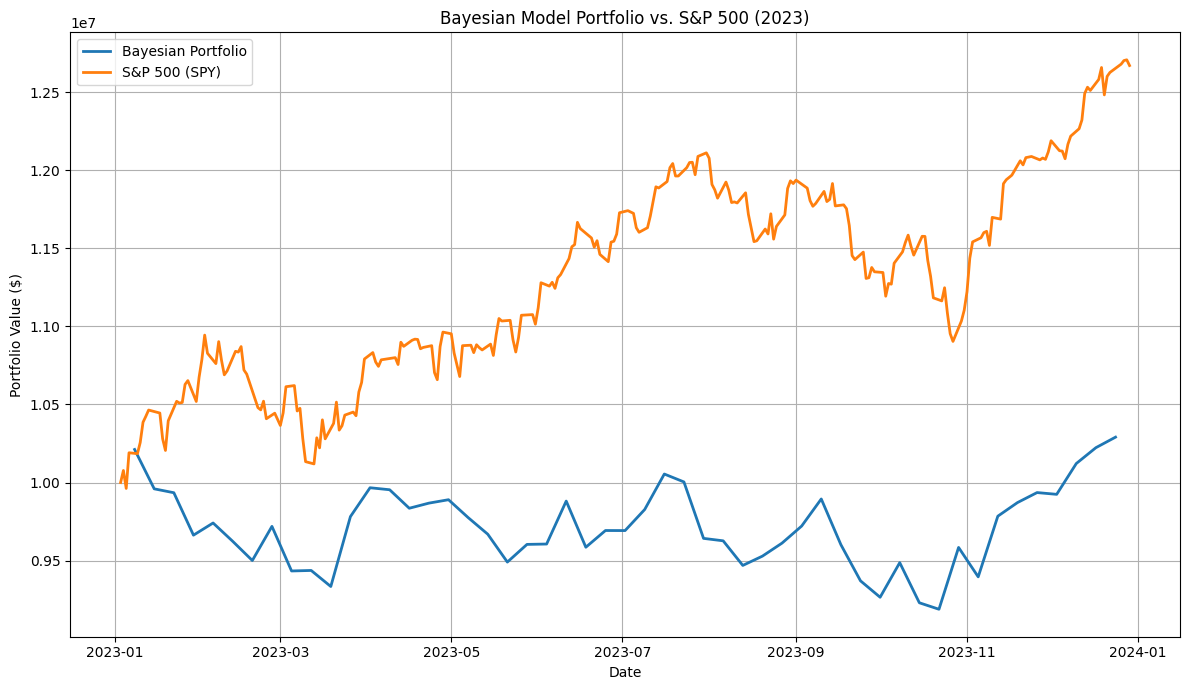

In [72]:
# Plot: Bayesian Portfolio vs. S&P 500 (SPY)
plt.figure(figsize=(12, 7))

plt.plot(portfolio_values_df['Date'], portfolio_values_df['Portfolio_Value'], label='Bayesian Portfolio', linewidth=2)
plt.plot(spy_daily_value.index, spy_daily_value, label='S&P 500 (SPY)', linewidth=2)

plt.title('Bayesian Model Portfolio vs. S&P 500 (2023)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bayesian Model Conclusion
The Bayesian inference model was introduced as an enhancement to the previous Linear Regression based portfolio selection strategy, incorporating prior knowledge to refine stock selection.  The goal was to leverage probabilistic modeling, accounting for uncertainty and dynamically adjusting invest allocations based on new data.

However, implementing a Bayesian model as a real time strategy entails significant computational demands.  Sampling inefficiencies such as tree depth issues, convergence problems, and prohibitively long execution times limited practicality for active investment.  Additionally, the final portfolio returns of 0.77% suggests that the strategy, in its current state, underperforms both the passive strategy of the previous two models, as well as simply investing in the S&P 500. 

Despite these challenges, Bayesian inference remains a promising approach with potential advantages over traditional regression-based strategies. Offering improved risk adjustment and adaptive decision making, which could provide a competitive advantage in volatile markets. Implementation would come at a high computational cost relative to performance, which may not be justifiable at this stage.  However, with further refinements this framework has the potential to evolve into a viable quantitative trading strategy.

# Project Conclusion

We set out to develop three quantitative investment strategies, Linear Regression, K-Means Clustering and Bayesian Inference to determine their effectiveness in outperforming the S&P 500.  

Both the Linear Regression and K-Means model generated competitive returns, with Linear Regression showing the highest potential for outperforming the S&P 500.  While Bayesian Inference remains a promising approach, it requires further optimization before it can be considered a viable strategy due to its high compuational demands.   

Our results is that it is feasible to outperform the S&P 500 using quantitative strategy.  However Future work should focus on:
 - Refining feature selection, as the vast amount of availabnle financial data could provide deeper insights into stock price movements
 - Improving computational efficiency, ensuring that models are scalable and pratical for real time execution
 - Exploring hybrid approaches, leveraging multiple models to improve decision making and maximize returns

By addressing these areas, quantitative strategies have the potential to offer a substantial edge over passive investment strategies like the S&P 500.  

## References
- Gao, Z. (2020). The application of artificial intelligence in stock investment. *Journal of Physics: Conference Series, 1453*, 012069. https://doi.org/10.1088/1742-6596/1453/1/012069

- Yahoo Finance. (2023). Stock market data: Historical prices & financial metrics. Yahoo! Inc. Retrieved from https://finance.yahoo.com/

- Wikipedia. (2024). List of S&P 500 companies. Retrieved on March 02, 2025, from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies